In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import pickle

import matplotlib.pyplot as plt
import time
from tqdm import trange

import matplotlib.pyplot as plt

In [2]:
from neural_nets import q_network, p_network, d_network
from sample_env import EnvSampler
from replay_memory import MemoryElement, ReplayMemory
from models import DynamicEnsemble, SAC, UniformPolicy
from utils import get_memories_torch, torchify

import torch.nn.functional as F

In [3]:
def roll_out(dynamic_model, real_memory, model_memory,agent, real_env , model_batch_size = 100, init = False):
        
    states, actions, rewards, next_states, terminals, truncateds = real_memory.sample_numpy(model_batch_size)

    horizon = agent.horizon
    for t in range(horizon):

        with torch.no_grad():
            if init:
                actions = real_env.sample_uniform_action(states)
                   
                #print(actions.shape)
            else:
                actions, log_prob = agent.act(states, to_cpu = True)
            next_states, rewards = dynamic_model.sample(states, actions, to_cpu = True)

        dones = real_env.check_done(next_states)

        for state, action, reward, next_state, terminal, truncated in zip(states, actions, rewards, next_states, dones,dones):
            mem_el = MemoryElement(state, action, reward, next_state, terminal, truncated)
            model_memory.push(mem_el)

        ixes = np.where(~(dones))[0]
        if len(ixes) == 0:
            break
        states = next_states[ixes]
        
        
def evaluate(agent, eval_env):
    eval_env.reset()

    trajectories = [[] for i in range(len(eval_env))]

    rewards = [0. for i in range(len(eval_env))]
    complete_trajectories = []
    complete_indexes = []
    while True:
        memories = eval_env.sample(agent=agent)

        for ix, mem in enumerate(memories):
            if ix in complete_indexes:
                continue

            trajectories[ix].append(mem)
            rewards[ix] += mem.reward
            rewards[ix]
            if mem.terminal or mem.truncated:
                complete_trajectories.append(trajectories[ix])
                complete_indexes.append(ix)

        if len(complete_indexes) == len(eval_env):
            break

    lengths = np.asarray([len(traj) for traj in complete_trajectories])
    rewards = np.asarray(rewards)

    return rewards, lengths


class CheckPointer():
    def __init__(self,agent, dynamic, real_mem, model_mem, real_env, eval_env):
        self.agent = agent
        self.dynamic = dynamic
        self.real_mem = real_mem
        self.model_mem = model_mem
        self.real_env = real_env
        self.eval_env = eval_env
    def save(self):
        with open(f'checkpoint/agent.pickle', 'wb') as file:
            pickle.dump(self.agent, file) 
        with open(f'checkpoint/dynamic.pickle', 'wb') as file:
            pickle.dump(self.dynamic, file) 
        with open(f'checkpoint/real_mem.pickle', 'wb') as file:
            pickle.dump(self.real_mem, file) 
        with open(f'checkpoint/model_mem.pickle', 'wb') as file:
            pickle.dump(self.model_mem, file) 
        with open(f'checkpoint/real_env.pickle', 'wb') as file:
            pickle.dump(self.real_env, file) 
        with open(f'checkpoint/eval_env.pickle', 'wb') as file:
            pickle.dump(self.eval_env, file) 
    def load(self):
        with open(f'checkpoint/agent.pickle', 'rb') as file:
            self.agent = pickle.load(file) 
        with open(f'checkpoint/dynamic.pickle', 'rb') as file:
            self.dynamic = pickle.load(file) 
        with open(f'checkpoint/real_mem.pickle', 'rb') as file:
            self.real_mem = pickle.load(file) 
        with open(f'checkpoint/model_mem.pickle', 'rb') as file:
            self.model_mem = pickle.load(file) 
        with open(f'checkpoint/real_env.pickle', 'rb') as file:
            self.real_env = pickle.load(file) 
        with open(f'checkpoint/eval_env.pickle', 'rb') as file:
            self.eval_env = pickle.load(file) 
            
    def get(self):
        return self.agent, self.dynamic, self.real_mem, self.model_mem, self.real_env, self.eval_env

In [4]:
env_name = 'Humanoid-v4'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
#env.seed(seed)

replay_size = 1000000
rollout_batch_size = 100
agent_batch_size = 256

num_models = 10



In [5]:
#Initialize real environment and real replay buffer
real_env = EnvSampler(env_name)
real_memory = ReplayMemory(replay_size)

#Initialize model buffer
model_memory = ReplayMemory(replay_size)

#Initialize evaluation environment
eval_env = EnvSampler(env_name, env_number = num_models)


E_step = 0
min_reward = np.inf
max_reward = -np.inf


agent = SAC(real_env)
dynamic_model = DynamicEnsemble(num_models, real_env, real_memory)

cp =  CheckPointer(agent, dynamic_model, real_memory, model_memory, real_env, eval_env)

In [6]:
cp.save()

In [19]:
cp.load()
agent, dynamic_model, real_memory, model_memory, real_env, eval_env = cp.get()

In [7]:
len(real_memory)

0

In [ ]:
#Initial data collection
for _ in trange(7500):
    real_memory_element = real_env.sample()[0]
    min_reward = min(real_memory_element.reward, min_reward)
    max_reward = max(real_memory_element.reward, max_reward)

    real_memory.push(real_memory_element)

#Initial model update
real_memory.fit_states()
for _ in trange(10000):
    dynamic_model.update_params(real_memory)
    if _ % 1500 == 0:
        cp.save()
    
#Initial rollout

for _ in trange(5000):
    roll_out(dynamic_model, real_memory, model_memory, agent, real_env = real_env, model_batch_size = rollout_batch_size, init= True)
    
cp.save()

100%|███████████████████████████████████▉| 9973/10000 [1:25:43<00:14,  1.87it/s]

In [65]:
for E in trange(2050):
    real_memory_element = real_env.sample(agent=agent)[0]
    min_reward = min(real_memory_element.reward, min_reward)
    max_reward = max(real_memory_element.reward, max_reward)

    real_memory.push(real_memory_element)
    
    if (E+1) %250 == 0:
        real_memory.fit_states()
        for _ in range(2000):
            dynamic_model.update_params(real_memory)
        cp.save()
    agent.update_C(min_reward, max_reward)

    for n_rollout in range(1):
        roll_out(dynamic_model, real_memory, model_memory, agent, real_env)
    
    #solver_updates_per_step = 10
    for n_actor in range(10):
        real_batch_size = agent_batch_size//10
        virtual_batch_size = agent_batch_size - real_batch_size

        memories = real_memory.sample(batch_size = real_batch_size) + model_memory.sample(batch_size = virtual_batch_size)
        agent.update_params(memories)

 12%|████▋                                 | 250/2050 [08:55<1:04:15,  2.14s/it]


KeyboardInterrupt: 

In [18]:
for i in range(10):
    r,l = evaluate(agent,eval_env)
    print(f'reward means : {r.mean()} - lengths : {l.mean()}')

reward means : -2318.219891571466 - lengths : 591.8
reward means : -2303.286400110244 - lengths : 591.8
reward means : -2301.5494328934933 - lengths : 591.8
reward means : -2299.925309110701 - lengths : 591.8
reward means : -2308.836005860048 - lengths : 591.8
reward means : -1993.6637641827758 - lengths : 513.1
reward means : -1998.3804862932825 - lengths : 513.1
reward means : -1975.0701471053787 - lengths : 513.1
reward means : -1981.8500312737076 - lengths : 513.1
reward means : -1987.6527688055933 - lengths : 513.1


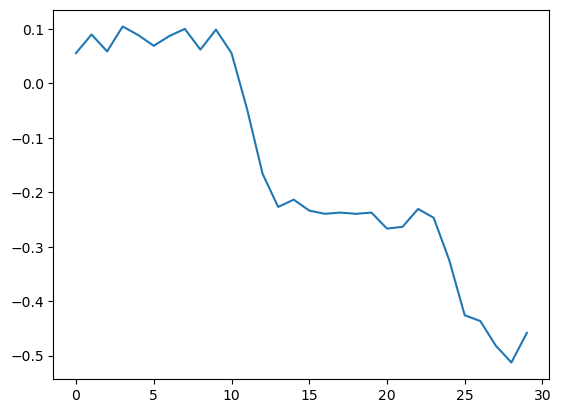

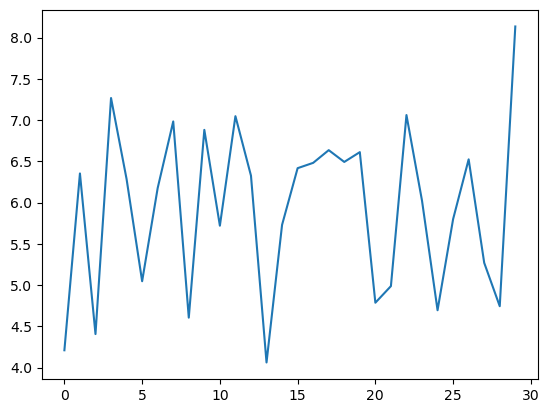

In [11]:
real_env.reset()
imgs= []
rewards = []
acts = []
for i in range(1000):
    mem = real_env.sample(agent=None)[0]
    rewards.append(mem.reward)
    acts.append((mem.action**2).sum())
    imgs.append(real_env.env.render())
    if mem.truncated or mem.terminal:
        break
    
plt.plot(rewards)
plt.show()

plt.plot(acts)
plt.show()

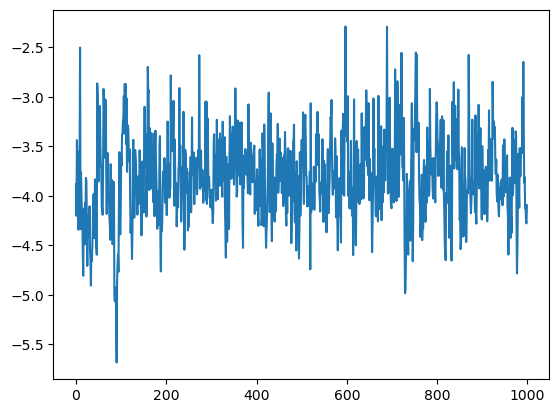

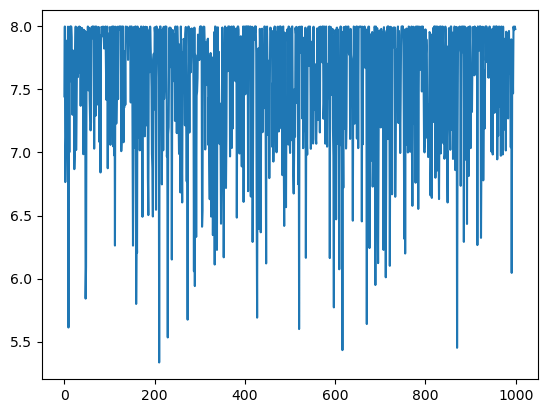

In [70]:
real_env.reset()
imgs= []
rewards = []
acts = []
for i in range(1000):
    mem = real_env.sample(agent=agent)[0]
    rewards.append(mem.reward)
    acts.append((mem.action**2).sum())
    imgs.append(real_env.env.render())
    if mem.truncated or mem.terminal:
        break
    
plt.plot(rewards)
plt.show()

plt.plot(acts)
plt.show()

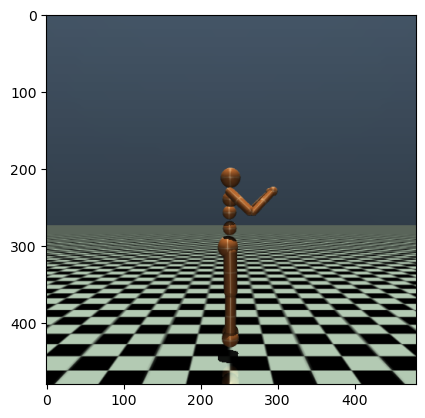

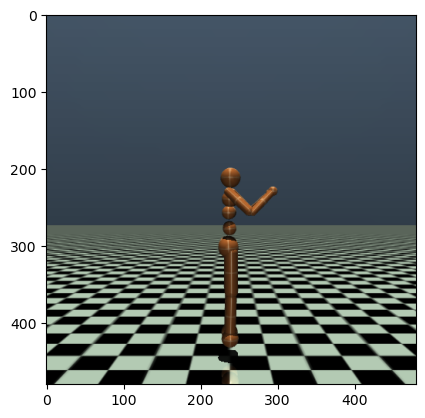

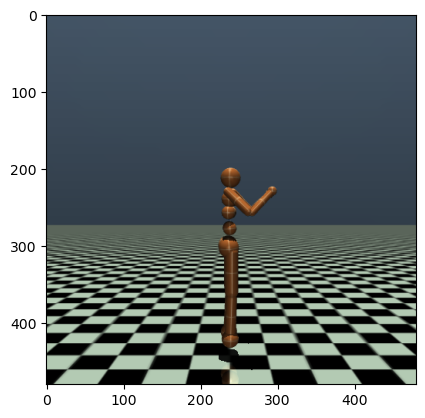

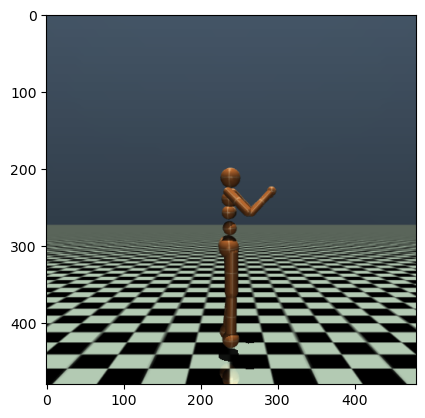

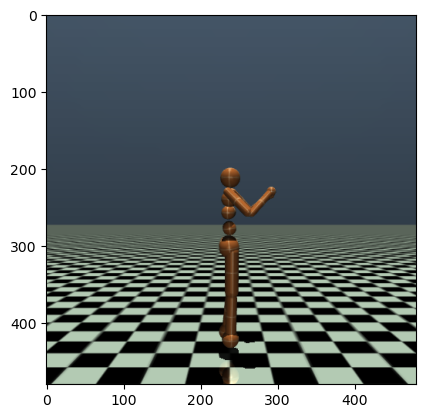

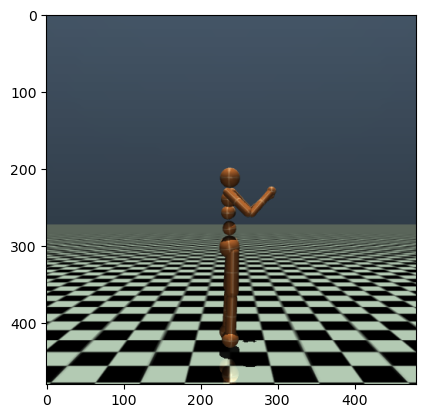

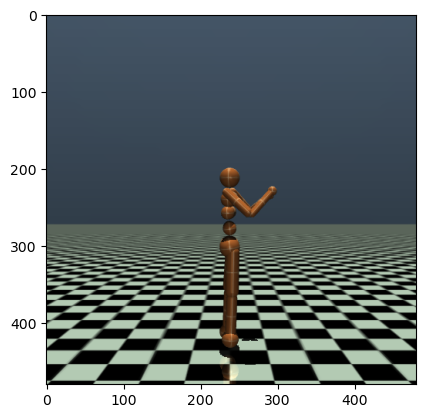

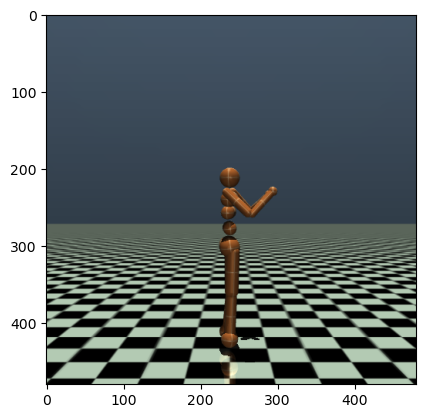

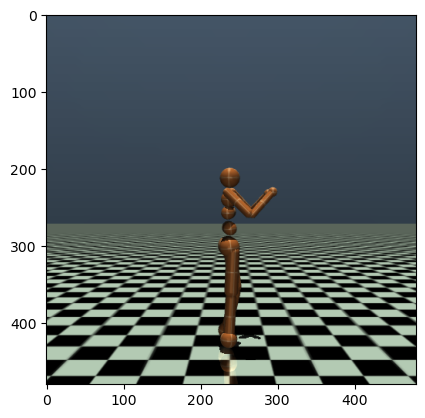

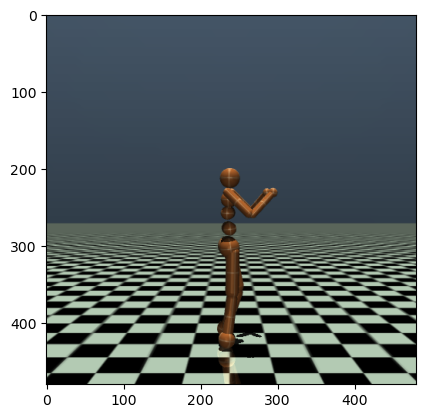

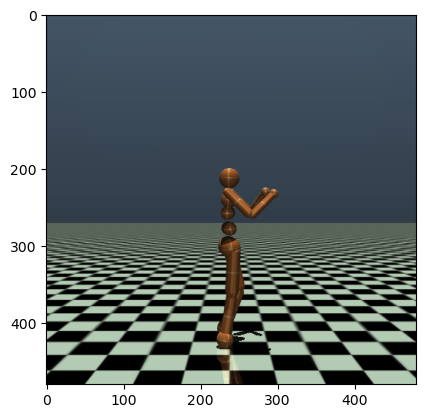

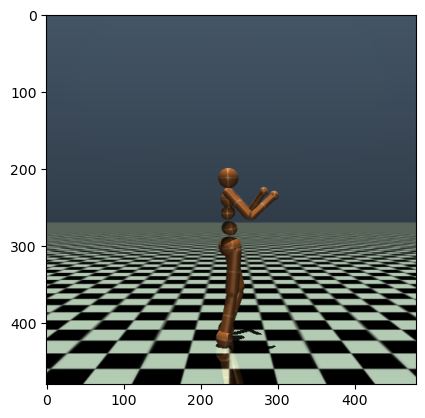

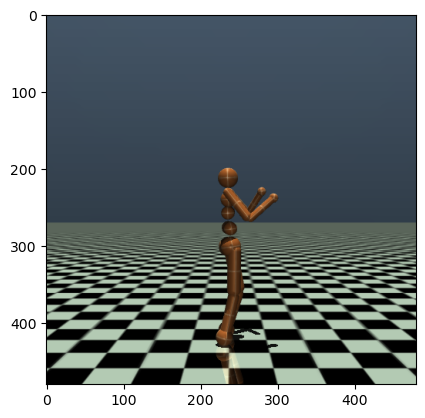

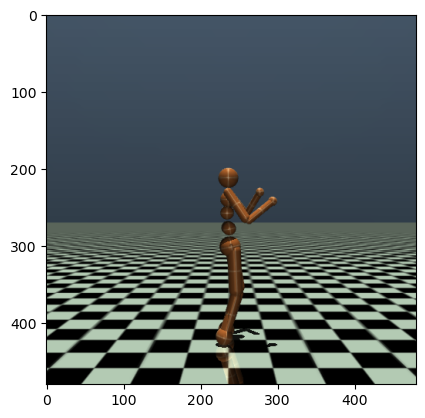

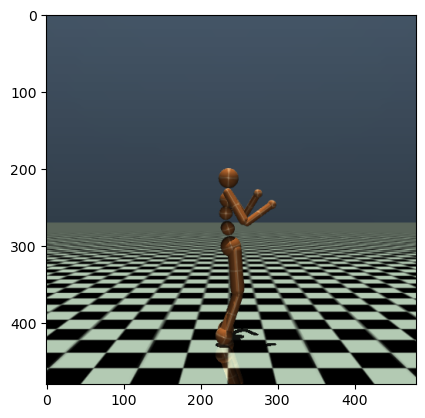

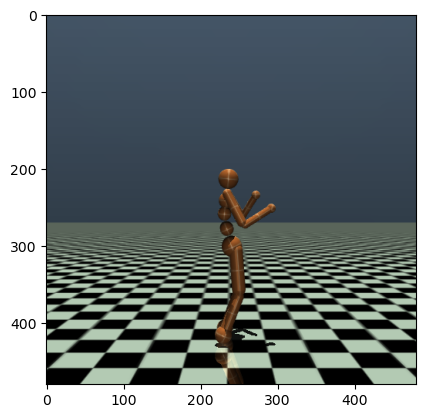

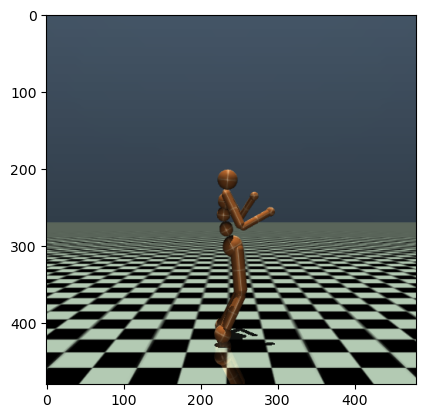

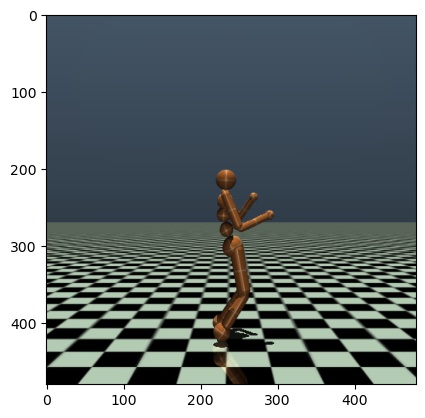

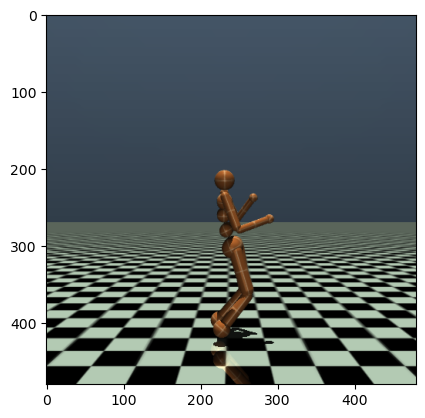

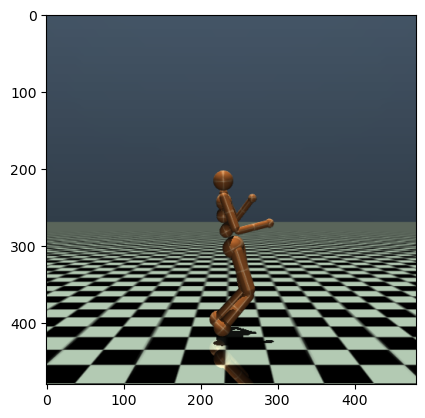

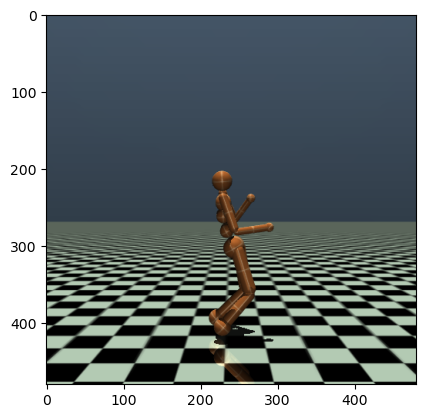

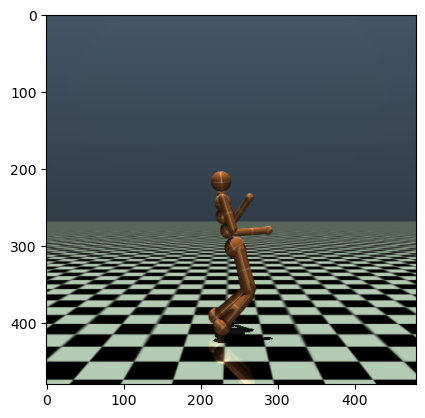

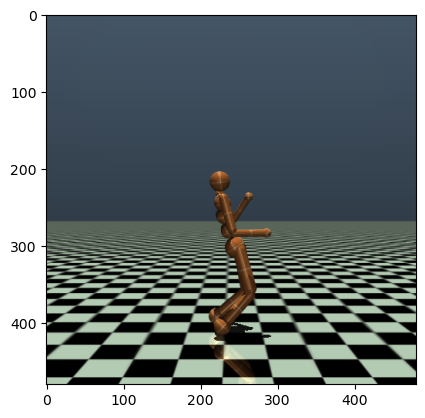

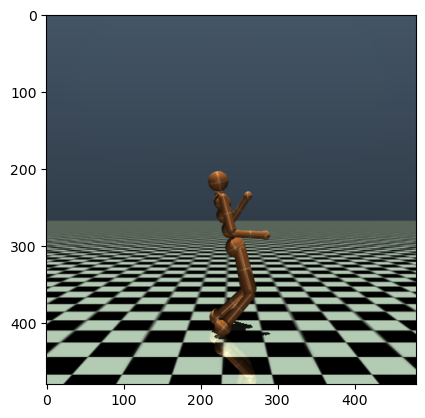

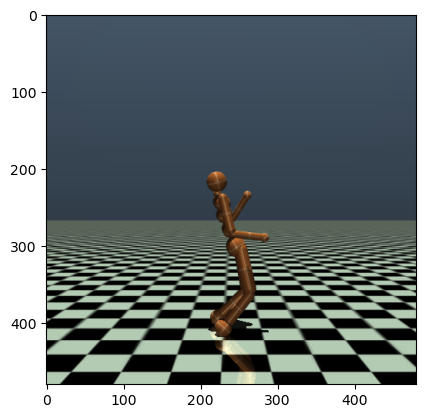

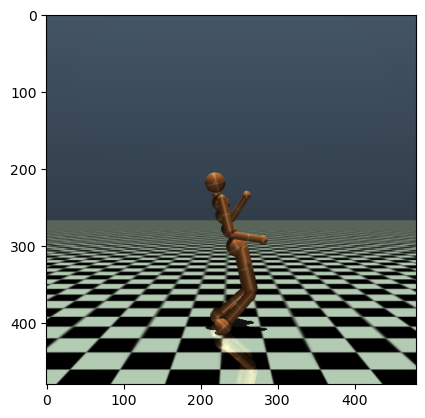

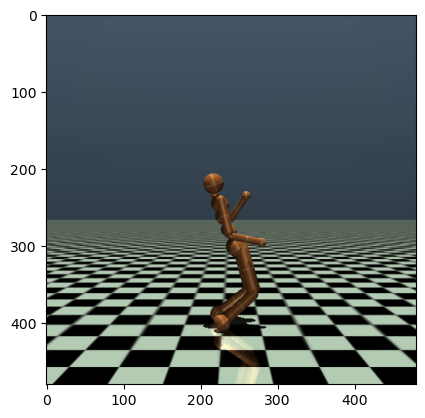

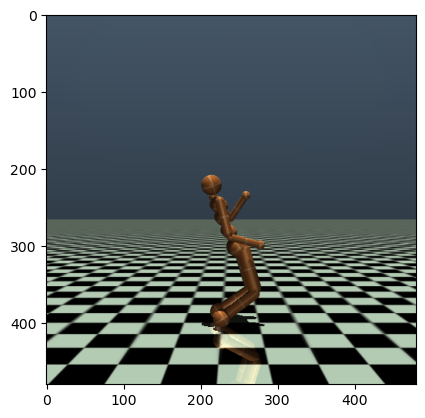

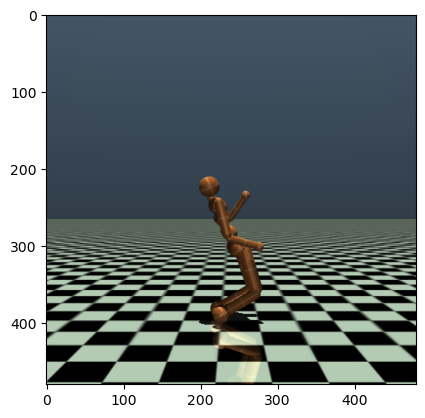

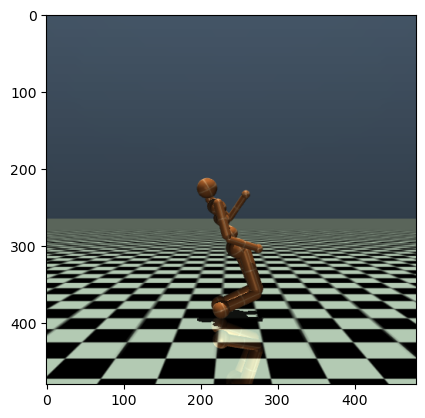

In [12]:
for img in imgs:
    plt.imshow(img)
    plt.show()

In [7]:
mem.next_state[0]

0.9664464709081478

In [14]:
agent

In [15]:
import pickle

with open(f'agent.pickle', 'wb') as file:
    pickle.dump(agent, file) 

In [7]:
agent.log_alpha.cpu().detach().numpy()

array(0.)